<a href="https://colab.research.google.com/github/reyndomly/braintumor/blob/main/Skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clone GitHub to access the Dataset

In [1]:
!git clone https://github.com/reyndomly/braintumor.git

Cloning into 'braintumor'...
remote: Enumerating objects: 6738, done.
remote: Total 6738 (delta 0), reused 0 (delta 0), pack-reused 6738
Receiving objects: 100% (6738/6738), 140.80 MiB | 34.73 MiB/s, done.
Checking out files: 100% (7023/7023), done.


#Import Library

In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from warnings import filterwarnings

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import imutils  

#Create Directories

In [3]:
#create directory for training data
os.mkdir('/content/Crop-Brain-MRI')
os.mkdir('/content/Crop-Brain-MRI/glioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/meningioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/pituitary_tumor')
os.mkdir('/content/Crop-Brain-MRI/no_tumor')

#create directory for testing data
os.mkdir('/content/Test-Data')
os.mkdir('/content/Test-Data/glioma_tumor')
os.mkdir('/content/Test-Data/meningioma_tumor')
os.mkdir('/content/Test-Data/pituitary_tumor')
os.mkdir('/content/Test-Data/no_tumor')

#Visualize Data

In [9]:
#specify directory
train_dir = '/content/braintumor/Training/'
test_dir = '/content/braintumor/Testing/'

In [10]:
#create classes
classes = os.listdir('/content/braintumor/Training/')

In [11]:
classes

['pituitary', 'glioma', 'meningioma', 'notumor']

In [12]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

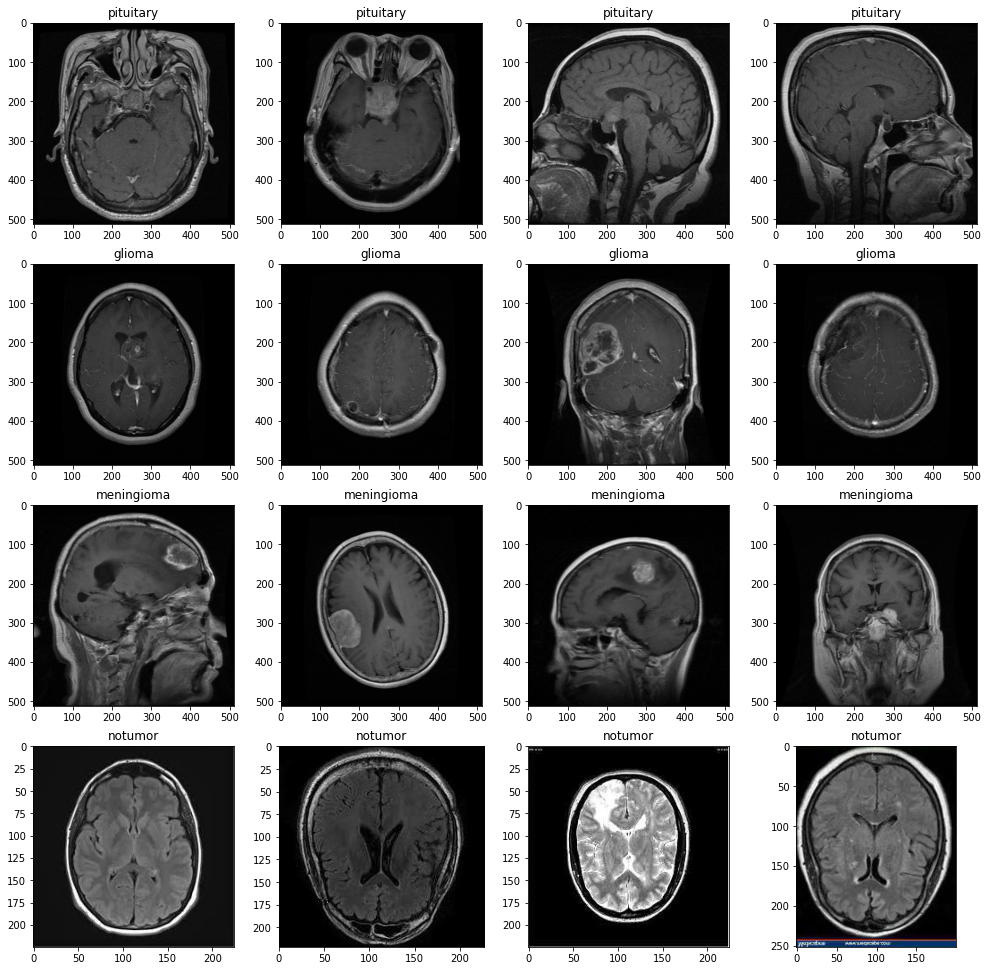

In [13]:
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [15]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('/content/braintumor/Training/'):
  train_class = os.listdir(os.path.join('/content/braintumor/Training/', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in pituitary = 1457 

Number of images in glioma = 1321 

Number of images in meningioma = 1339 

Number of images in notumor = 1595 



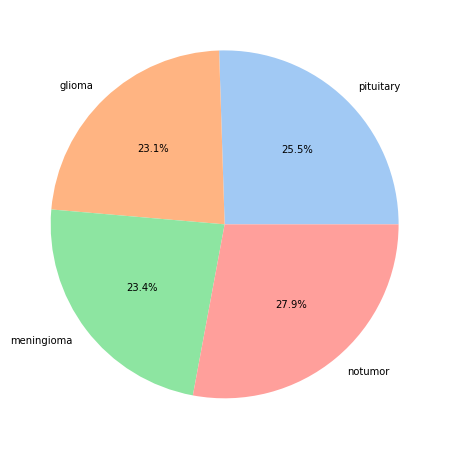

In [16]:
#visualize class distribution in train set
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

#Crop Images

In [17]:

def crop_image(image, plot=False):
    
    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    #apply binary threshhold
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #generate new image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    #plot
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image



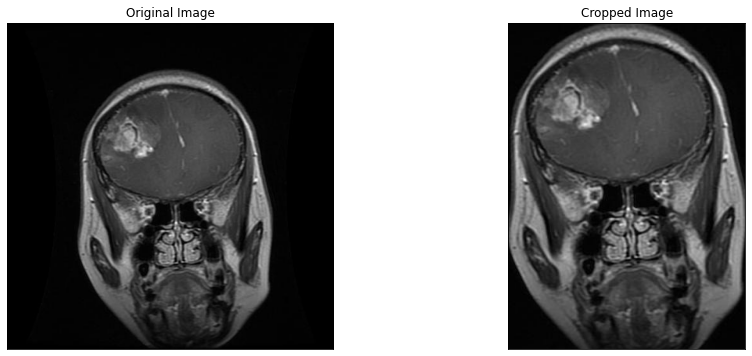

In [19]:
example_image = cv2.imread('/content/braintumor/Training/glioma/Tr-glTr_0000.jpg')
cropped_image = crop_image(example_image, plot=True)

In [20]:
width = 240
height = 240
size = (width,height)

In [22]:
#crop training images and save it to the directory we previously created
glioma = train_dir + 'glioma'
meningioma = train_dir + 'meningioma'
pituitary = train_dir + 'pituitary'
no_tumor = train_dir + 'notumor'

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img,size)
    save_path = '/content/Crop-Brain-MRI/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, size)
    save_path = '/content/Crop-Brain-MRI/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, size)
    save_path = '/content/Crop-Brain-MRI/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, size)
    save_path = '/content/Crop-Brain-MRI/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

100%|██████████| 1595/1595 [00:06<00:00, 242.23it/s]


In [23]:
#crop testing images and save it to the directory we previously created
test_glioma = test_dir + 'glioma'
test_meningioma = test_dir + 'meningioma'
test_pituitary = test_dir + 'pituitary'
test_no_tumor = test_dir + 'notumor'

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  #img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, size)
    save_path = '/content/Test-Data/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  #img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, size)
    save_path = '/content/Test-Data/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  #img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, size)
    save_path = '/content/Test-Data/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  #img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, size)
    save_path = '/content/Test-Data/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

100%|██████████| 405/405 [00:01<00:00, 369.67it/s]


#Data Preparation

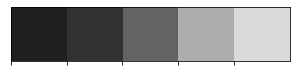

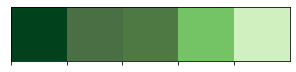

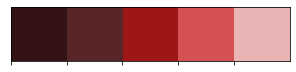

In [24]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [26]:
X_train = []
y_train = []
image_size = 240
for i in classes:
    folderPath = os.path.join('/content/Crop-Brain-MRI',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in classes:
    folderPath = os.path.join('/content/Test-Data',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 405/405 [00:00<00:00, 1054.49it/s]


In [27]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [28]:
X_train.shape

(7023, 240, 240, 3)

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [32]:
X_train.shape

(5618, 240, 240, 3)

In [30]:
y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

#Model Achitect

In [33]:
#build the model
effnet = EfficientNetB1(weights='imagenet', 
                        include_top=False, 
                        input_shape=(image_size, image_size, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5, seed=123)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)

#get summary()
model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

#Compile

In [34]:
#compile model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#tensorboard
tensorboard = TensorBoard(log_dir = 'logs')

#define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 3, 
                              min_delta = 0.001, #0.001 normale
                              mode='auto',
                              verbose=1)

#Train the Model

In [35]:
#train the model
history = model.fit(X_train,
                    y_train,
                    validation_split=0.1,
                    epochs=30,
                    verbose=1,
                    batch_size=32,
                    callbacks=[tensorboard,checkpoint, earlystop,reduce_lr])

Epoch 1/30
158/158 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.8995
Epoch 1: val_accuracy improved from -inf to 0.96085, saving model to model.h5
158/158 [==============================] - 85s 391ms/step - loss: 0.2810 - accuracy: 0.8995 - val_loss: 0.1859 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 2/30
158/158 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9614
Epoch 2: val_accuracy did not improve from 0.96085
158/158 [==============================] - 58s 365ms/step - loss: 0.1122 - accuracy: 0.9614 - val_loss: 0.2741 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 3/30
158/158 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9759
Epoch 3: val_accuracy did not improve from 0.96085
158/158 [==============================] - 57s 363ms/step - loss: 0.0767 - accuracy: 0.9759 - val_loss: 0.7533 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 4/30
158/158 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.

KeyboardInterrupt: ignored

NameError: ignored

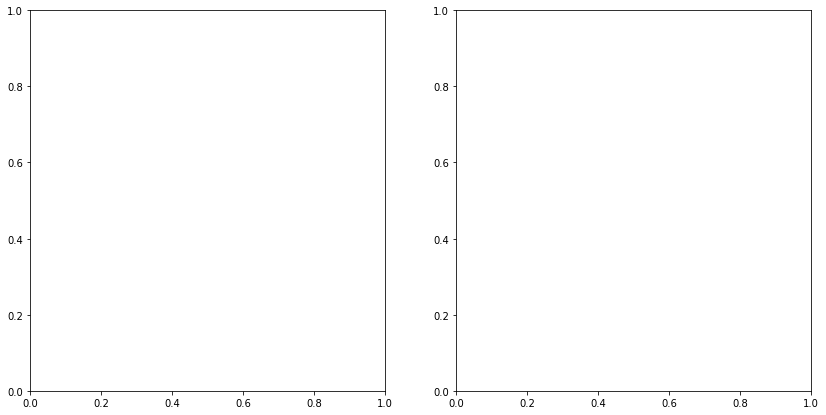

In [36]:
filterwarnings('ignore')

epochs = [i for i in range(21)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [37]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
y_test_new

In [38]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       383
           1       0.99      0.99      0.99       315
           2       0.98      0.99      0.99       328
           3       0.99      1.00      1.00       379

    accuracy                           0.99      1405
   macro avg       0.99      0.99      0.99      1405
weighted avg       0.99      0.99      0.99      1405



In [39]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[378   0   3   2]
 [  0 312   2   1]
 [  1   2 325   0]
 [  0   0   0 379]]


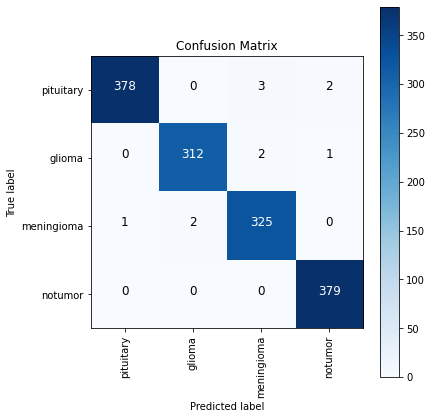

In [40]:
#get confusion matrix
cm = confusion_matrix(y_test_new, pred)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [44]:
import PIL

class_dict = {0: 'pituitary',
              1: 'glioma',
              2: 'meningioma',
              3: 'notumor'}
              
prediction = []
original = []
image = []
count = 0
for i in os.listdir('/content/Test-Data/'):
  for item in os.listdir(os.path.join('/content/Test-Data/', i)):
    # code to open the image
    img= PIL.Image.open(os.path.join('/content/Test-Data/', i, item))
    #append to image list
    image.append(img)
    #expand dimension
    img = np.expand_dims(img, axis=0)
    #predict
    predict = model.predict(img)
    #get the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #append the predicted class to the list
    prediction.append(class_dict[predict])
    #append original class to the list
    original.append(i)

In [45]:
#test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.9984744469870328


In [ ]:
original

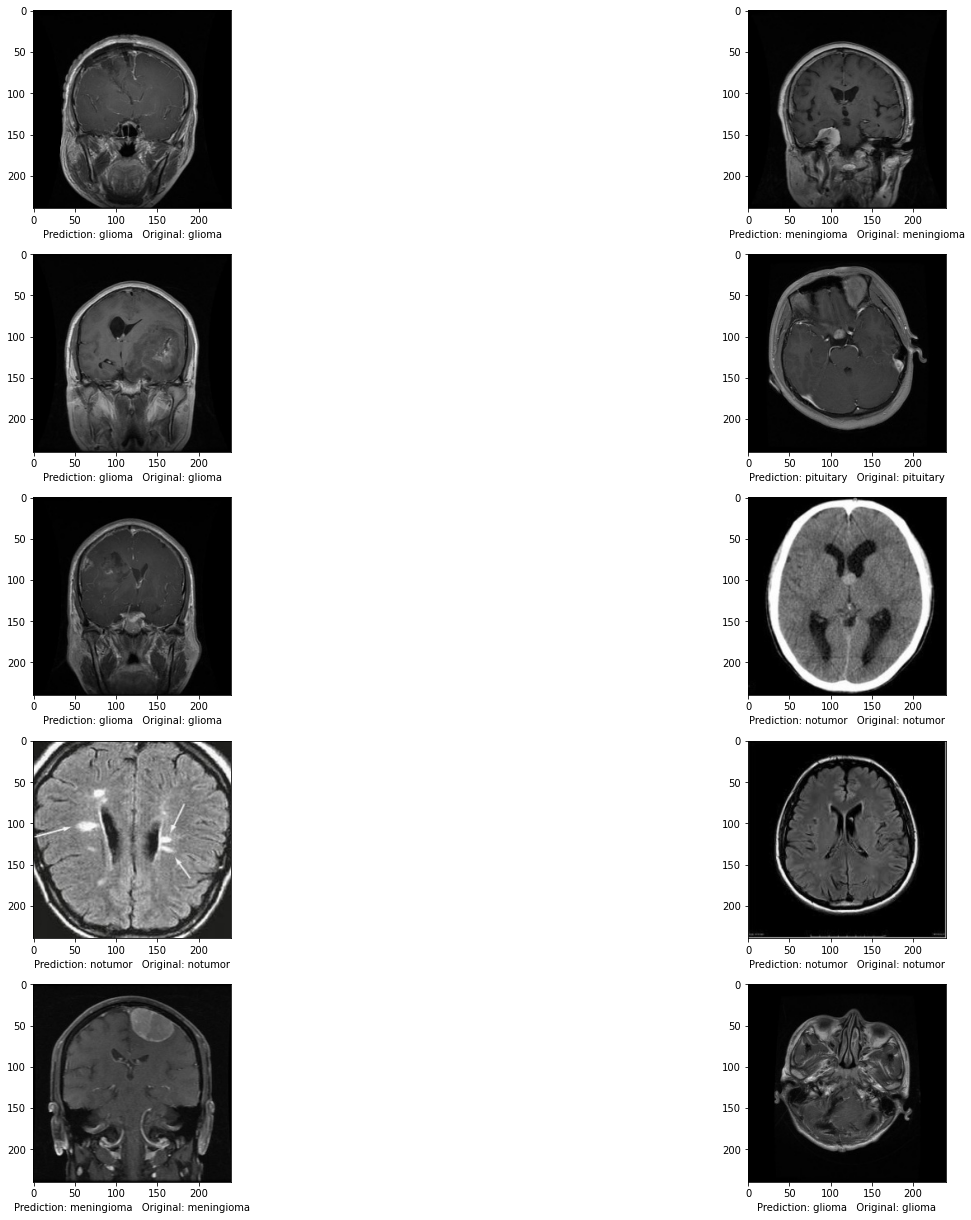

In [46]:
#visualize the results
fig = plt.figure(figsize = (20, 20))
for i in range(10):
    j = random.randint(0, len(image))
    fig.add_subplot(6, 2, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [47]:
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [48]:
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

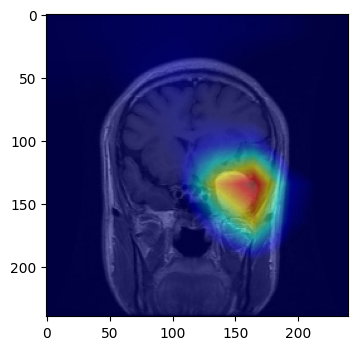

In [50]:
#load image
test_img = cv2.imread("/content/Test-Data/meningioma/0.jpg")

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

In [ ]:
def CompareVisual(image,plot=False) :
  new_image = VizGradCAM(model, img_to_array(image), plot_results=True)

  if plot:
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(new_image)
    plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Cropped Image')
    plt.show()

  return new_image

In [51]:
!cp '/content/model.h5' '/content/drive/MyDrive/Model Skripsi'